# Product Recommendation — Training Notebook

This notebook reproduces the training workflow from `scripts/product_recommendation.py`.
It loads the aggregated merged dataset, builds preprocessing pipelines, trains a RandomForest baseline and an XGBoost comparator, saves trained pipelines, and displays evaluation metrics and top feature importances.

In [1]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib
import os
import pandas as pd
import numpy as np

print('Imports OK')

Imports OK


In [2]:
def load_merged_aggregated():
    agg_path = os.path.join('merge-output', 'merged_data_aggregated.csv')
    fallback_path = os.path.join('merge-output', 'merged_data.csv')

    if os.path.exists(agg_path):
        return pd.read_csv(agg_path)

    trans_path = os.path.join('Customer_Dataset', 'customer_transactions.csv')
    social_path = os.path.join('Customer_Dataset', 'customer_social_profiles.csv')
    if os.path.exists(trans_path) and os.path.exists(social_path):
        trans = pd.read_csv(trans_path)
        social = pd.read_csv(social_path)
        trans = trans.copy()
        trans['customer_id_new'] = 'A' + trans['customer_id_legacy'].astype(str)

        agg_num = social.groupby('customer_id_new').agg({
            'engagement_score': 'mean',
            'purchase_interest_score': 'mean'
        }).rename(columns={'engagement_score':'avg_engagement_score','purchase_interest_score':'avg_purchase_interest_score'})
        mode_sentiment = social.groupby('customer_id_new')['review_sentiment'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        mode_platform = social.groupby('customer_id_new')['social_media_platform'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        counts = social.groupby('customer_id_new').size().rename('social_profile_count')
        agg_social = agg_num.join(mode_sentiment.rename('dominant_sentiment')).join(mode_platform.rename('dominant_platform')).join(counts).reset_index()

        merged_agg = trans.merge(agg_social, on='customer_id_new', how='left')
        os.makedirs('merge-output', exist_ok=True)
        merged_agg.to_csv(agg_path, index=False)
        return merged_agg

    if os.path.exists(fallback_path):
        return pd.read_csv(fallback_path)

    raise FileNotFoundError('No merged dataset found. Run merge scripts to create merge-output/merged_data_aggregated.csv or provide source Customer_Dataset files.')

# Load dataframe
df = load_merged_aggregated()
print('Loaded merged dataframe with shape:', df.shape)

Loaded merged dataframe with shape: (150, 12)


In [3]:
# Prepare model dataframe (drop identifiers)
model_df = df.drop(columns=[c for c in ['transaction_id', 'purchase_date', 'customer_id_new'] if c in df.columns])

# Candidate features (keep as in script)
categorical_features = ['social_media_platform', 'review_sentiment']
numerical_features = ['purchase_amount', 'customer_rating', 'engagement_score', 'purchase_interest_score']

# Detect available features in the merged/aggregated dataframe
available_num = [c for c in numerical_features if c in model_df.columns]
available_cat = [c for c in categorical_features if c in model_df.columns]
features_for_model = available_num + available_cat

if len(features_for_model) == 0:
    raise ValueError(f'No model features found in dataframe. Expected any of: {numerical_features + categorical_features}')

X = model_df[features_for_model].copy()
y = model_df['product_category'].copy()

# Encode target and drop missing target rows
le = LabelEncoder()
notnull_mask = y.notnull()
X = X.loc[notnull_mask]
y = y.loc[notnull_mask]
y_encoded = le.fit_transform(y)
print('Prepared X/y shapes:', X.shape, y_encoded.shape)

Prepared X/y shapes: (150, 2) (150,)


In [4]:
# Build preprocessing pipelines using detected feature lists
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_cols_for_transform = available_num
cat_cols_for_transform = available_cat

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols_for_transform),('cat', categorical_transformer, cat_cols_for_transform)], remainder='drop')

# Create the pipeline with RandomForest classifier
product_model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),('classifier', RandomForestClassifier(random_state=42))])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
print('Train/test sizes:', X_train.shape, X_test.shape)

Train/test sizes: (105, 2) (45, 2)


In [5]:
# Train RandomForest baseline
product_model_pipeline.fit(X_train, y_train)
y_pred = product_model_pipeline.predict(X_test)

print("RandomForest Product Recommendation Model Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Save baseline model and label encoder
os.makedirs('trained-models/models', exist_ok=True)
joblib.dump(product_model_pipeline, 'trained-models/models/product_model_randomforest.joblib')
joblib.dump(le, 'trained-models/models/label_encoder.joblib')
print('Saved RandomForest model and label encoder to trained-models/models/')

RandomForest Product Recommendation Model Performance:


Accuracy: 0.1556
F1-Score (weighted): 0.1555
Classification Report:
              precision    recall  f1-score   support

       Books       0.25      0.12      0.17         8
    Clothing       0.14      0.12      0.13         8
 Electronics       0.18      0.20      0.19        10
   Groceries       0.20      0.25      0.22         8
      Sports       0.08      0.09      0.08        11

    accuracy                           0.16        45
   macro avg       0.17      0.16      0.16        45
weighted avg       0.16      0.16      0.16        45



Saved RandomForest model and label encoder to trained-models/models/

In [6]:
# Train XGBoost as a comparator (best-effort)
try:
    product_model_pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))])
    product_model_pipeline_xgb.fit(X_train, y_train)
    y_pred_xgb = product_model_pipeline_xgb.predict(X_test)
    print("XGBoost Product Recommendation Model Performance:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
    print(f"F1-Score (weighted): {f1_score(y_test, y_pred_xgb, average='weighted'):.4f}")
    print(classification_report(y_test, y_pred_xgb, target_names=le.classes_))
    joblib.dump(product_model_pipeline_xgb, 'trained-models/models/product_model_xgb.joblib')
    print('Saved XGBoost model to trained-models/models/')
except Exception as e:
    print('XGBoost training skipped or failed:', str(e))

C:\Users\LENOVO\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:199: UserWarning: [18:40:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Product Recommendation Model Performance:
Accuracy: 0.1556
F1-Score (weighted): 0.1521
              precision    recall  f1-score   support

       Books       0.25      0.12      0.17         8
    Clothing       0.25      0.25      0.25         8
 Electronics       0.00      0.00      0.00        10
   Groceries       0.17      0.25      0.20         8
      Sports       0.17      0.18      0.17        11

    accuracy                           0.16        45
   macro avg       0.17      0.16      0.16        45
weighted avg       0.16      0.16      0.15        45

Saved XGBoost model to trained-models/models/


In [7]:
# Extract and display top feature importances from saved pipelines
def get_feature_names_from_preprocessor(preprocessor):
    try:
        return list(preprocessor.get_feature_names_out())
    except Exception:
        names = []
        try:
            for name, trans, cols in preprocessor.transformers:
                if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
                    ohe = trans.named_steps['onehot']
                    try:
                        ohe_names = ohe.get_feature_names_out(cols)
                    except Exception:
                        ohe_names = [f"{c}_{i}" for c in cols for i in range(len(ohe.categories_))]
                    names.extend(list(ohe_names))
                else:
                    names.extend(list(cols))
        except Exception:
            pass
        return names

def print_importances_from_pipeline(path, model_name):
    if not os.path.exists(path):
        print(f"{model_name} not found at {path}")
        return
    pipe = joblib.load(path)
    print(f"Loaded pipeline: {path}")
    if 'preprocessor' in pipe.named_steps:
        feat_names = get_feature_names_from_preprocessor(pipe.named_steps['preprocessor'])
    else:
        feat_names = []
    clf = pipe.named_steps.get('classifier')
    if clf is None:
        print('No classifier in pipeline')
        return
    importances = None
    if hasattr(clf, 'feature_importances_'):
        importances = clf.feature_importances_
    elif hasattr(clf, 'coef_'):
        importances = np.abs(clf.coef_).mean(axis=0)
    if importances is None:
        print('Model does not expose feature importances')
        return
    if len(feat_names) != len(importances):
        feat_names = feat_names or [f'f{i}' for i in range(len(importances))]
    idx = np.argsort(importances)[::-1]
    print(f"Top features for {model_name}:")
    for i in idx[:15]:
        print(f"  {feat_names[i]}: {importances[i]:.4f}")

print_importances_from_pipeline('trained-models/models/product_model_randomforest.joblib', 'RandomForest')
print('')
print_importances_from_pipeline('trained-models/models/product_model_xgb.joblib', 'XGBoost')

Loaded pipeline: trained-models/models/product_model_randomforest.joblib
Top features for RandomForest:
  num__purchase_amount: 0.5847
  num__customer_rating: 0.4153

Loaded pipeline: trained-models/models/product_model_xgb.joblib
Top features for XGBoost:
  num__customer_rating: 0.5362
  num__purchase_amount: 0.4638


In [8]:
# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
print('Plot libs ready')

Plot libs ready


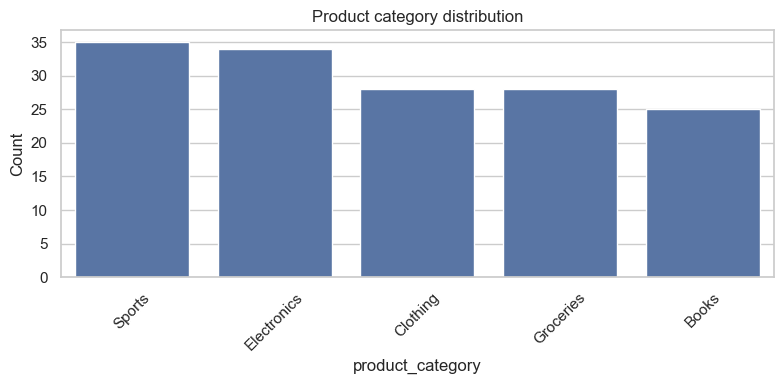

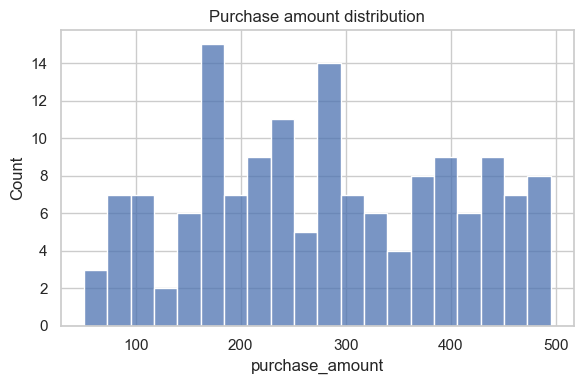

In [9]:
# Category distribution and purchase_amount histogram
if 'product_category' in df.columns:
    counts = df['product_category'].value_counts()
    plt.figure(figsize=(8,4))
    sns.barplot(x=counts.index, y=counts.values)
    plt.xticks(rotation=45)
    plt.title('Product category distribution')
    plt.ylabel('Count')
    plt.tight_layout()
else:
    print('product_category not in df')

if 'purchase_amount' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['purchase_amount'].dropna(), kde=False, bins=20)
    plt.title('Purchase amount distribution')
    plt.tight_layout()
else:
    print('purchase_amount not in df')

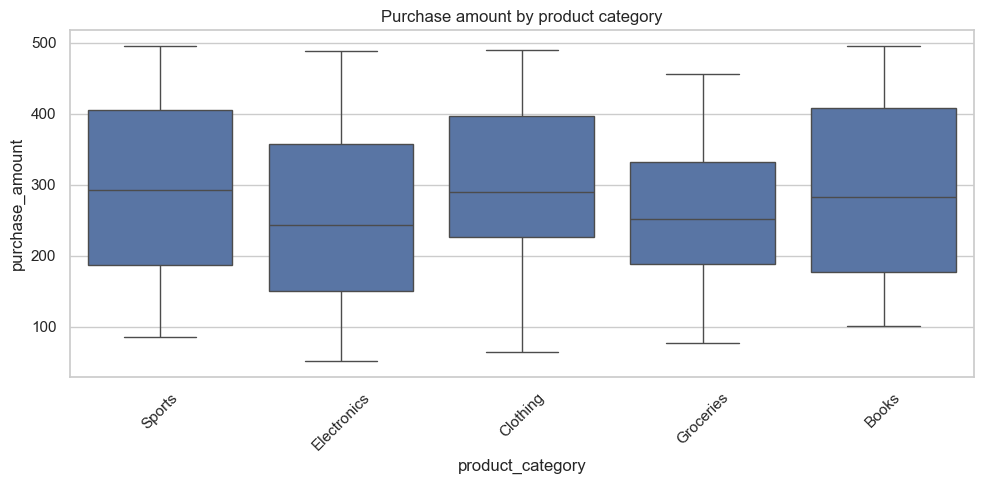

In [10]:
# Boxplot of purchase amount by product category
if 'purchase_amount' in df.columns and 'product_category' in df.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='product_category', y='purchase_amount', data=df)
    plt.xticks(rotation=45)
    plt.title('Purchase amount by product category')
    plt.tight_layout()
else:
    print('Required columns missing for boxplot')

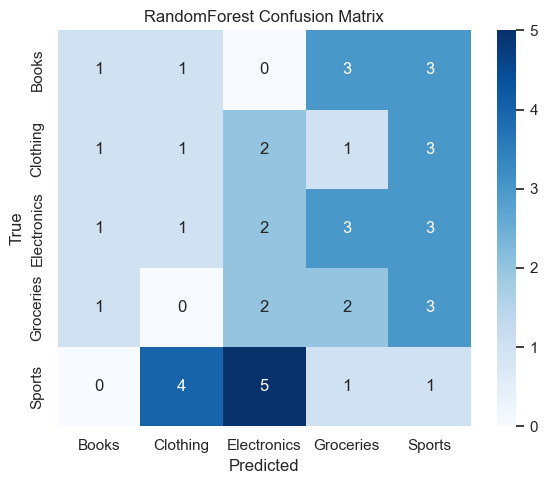

In [11]:
# Confusion matrix for RandomForest (requires y_test and y_pred to be defined by previous cells)
from sklearn.metrics import confusion_matrix
if 'y_test' in globals() and 'y_pred' in globals():
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('RandomForest Confusion Matrix')
    plt.tight_layout()
else:
    print('y_test or y_pred not available in notebook scope')

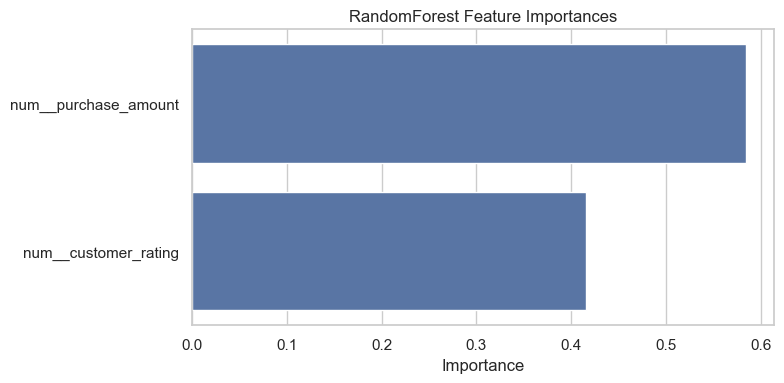

In [12]:
# Plot RandomForest feature importances (loads saved pipeline)
try:
    rf_pipe = joblib.load('trained-models/models/product_model_randomforest.joblib')
    pre = rf_pipe.named_steps['preprocessor']
    clf = rf_pipe.named_steps['classifier']
    feat_names = []
    try:
        feat_names = list(pre.get_feature_names_out())
    except Exception:
        for name, trans, cols in pre.transformers:
            if hasattr(trans, 'named_steps') and 'onehot' in trans.named_steps:
                ohe = trans.named_steps['onehot']
                try:
                    feat_names.extend(list(ohe.get_feature_names_out(cols)))
                except Exception:
                    feat_names.extend(cols)
            else:
                feat_names.extend(cols)
    importances = clf.feature_importances_
    idx = importances.argsort()[::-1]
    plt.figure(figsize=(8,4))
    sns.barplot(x=importances[idx], y=[feat_names[i] for i in idx])
    plt.title('RandomForest Feature Importances')
    plt.xlabel('Importance')
    plt.tight_layout()
except Exception as e:
    print('Could not plot feature importances:', e)